In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
project_path = "/content/drive/MyDrive/DL/U-Net"
os.chdir(project_path)
print("Current directory:", os.getcwd())

Current directory: /content/drive/MyDrive/DL/U-Net


In [4]:
import torch
import wandb
from u_net import U_Net
from data import get_data, view
from loops import training_loop, performance_report

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
wandb.login()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mkwambetumelo to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [6]:
train_data = get_data('train', [2, 7, 10, 12, 21, 24, 27, 28, 30, 43])
val_data = get_data('val', [1, 11, 22, 32])
test_data = get_data('test', [4, 16, 29, 36])

In [17]:
model = U_Net(
    in_channels = 3,
    out_channels = 2,
    start_channels = 64,
    depth = 4,
    bilinear = False
)

In [18]:
model = training_loop(
    model = model,
    training_data = train_data,
    validation_data = val_data,
    run_name = "unet_run1",
    batch = 4,
    learning_rate = 1e-3,
    num_epochs = 15,
    device = device
)

torch.torch.cuda.empty_cache()

Epoch: 0
Training | Loss: 0.6881301204363505
Validation | Loss: 0.6011362671852112 | Accuracy: 0.7605050404866537 | Precision: 0.5783679166056067 | Recall: 0.7605050404866537 | F1: 0.6570477258568136 

Epoch: 1
Training | Loss: 0.6856744488080343
Validation | Loss: 0.6020709872245789 | Accuracy: 0.7605050404866537 | Precision: 0.5783679166056067 | Recall: 0.7605050404866537 | F1: 0.6570477258568136 

Epoch: 2
Training | Loss: 0.6756862998008728
Validation | Loss: 0.6233681440353394 | Accuracy: 0.7605050404866537 | Precision: 0.5783679166056067 | Recall: 0.7605050404866537 | F1: 0.6570477258568136 

Epoch: 3
Training | Loss: 0.6674652099609375
Validation | Loss: 0.5726351141929626 | Accuracy: 0.7825180689493815 | Precision: 0.8308810755231386 | Recall: 0.7825180689493815 | F1: 0.705687419505329 

Epoch: 4
Training | Loss: 0.6480146249135336
Validation | Loss: 0.5262475609779358 | Accuracy: 0.9540551503499349 | Precision: 0.9561257893868187 | Recall: 0.9540551503499349 | F1: 0.9524179305

Training Loss,███▇▇▅▅▃▁▁▆▆▂▂▂
Validation Accuracy,▆▆▆▆█████▁███▄█
Validation F1,▅▅▅▆█████▁███▅█
Validation Loss,▃▃▃▃▃▂▂▁▁█▁▁▂▃▂
Validation Precision,▁▁▁▅█▇███▅▇▇█▆█
Validation Recall,▆▆▆▆█████▁███▄█
Training Loss,0.48901
Validation Accuracy,0.98101
Validation F1,0.98095
Validation Loss,0.43332
Validation Precision,0.98094


In [31]:
model = model.to("cpu")
image = test_data[3][0]
image = image.unsqueeze(0)
out_image = model(image)

In [32]:
out_image = torch.argmax(out_image, dim = 1)
out_image = out_image.squeeze(0)

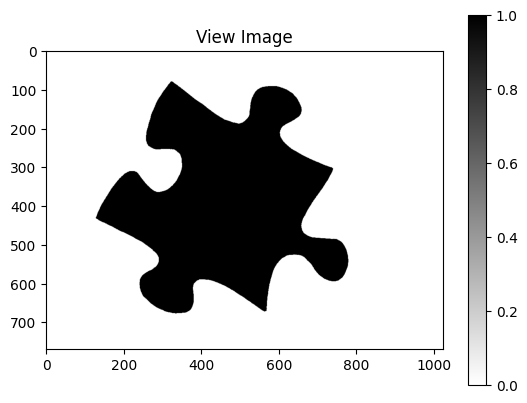

In [33]:
view(test_data[3][1])

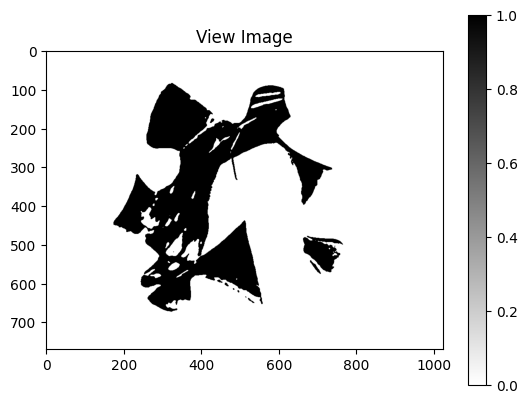

In [34]:
view(out_image)